In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, warnings
warnings.filterwarnings("ignore")
from IPython.display import display, HTML
from sklearn import preprocessing, model_selection, metrics, feature_selection
%matplotlib inline


In [4]:
# read the datafile
df_read = pd.read_excel('Online Retail.xlsx',encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceNo': str})

In [5]:
df_initial= df_read

In [6]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     541909 non-null object
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [8]:
np.random.seed(1)
df_initial = df_initial.sample(frac=1).reset_index(drop=True)

In [9]:
df_initial= df_initial[:50000]

In [10]:
# gives some infos on columns types and numer of null values
tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column dtype'})
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index = {0:'null values'}))
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column dtype,object,object,object,int64,datetime64[ns],float64,object,object
null values,0,0,132,0,0,0,0,0
null values (%),0,0,0.264,0,0,0,0,0


The column Description has 26.4 % of null values. Lets drop all of them from the model.

In [11]:
df_initial.dropna(axis = 0,inplace = True)
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49868 entries, 0 to 49999
Data columns (total 8 columns):
InvoiceNo      49868 non-null object
StockCode      49868 non-null object
Description    49868 non-null object
Quantity       49868 non-null int64
InvoiceDate    49868 non-null datetime64[ns]
UnitPrice      49868 non-null float64
CustomerID     49868 non-null object
Country        49868 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 3.4+ MB


In [12]:
# gives some infos on columns types and numer of null values
tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column dtype'})
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index = {0:'null values'}))
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column dtype,object,object,object,int64,datetime64[ns],float64,object,object
null values,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


The null values are now moved out, repeat the same with duplicates

In [13]:
print('Duplicate entries: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Duplicate entries: 48


In [14]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49820 entries, 0 to 49999
Data columns (total 8 columns):
InvoiceNo      49820 non-null object
StockCode      49820 non-null object
Description    49820 non-null object
Quantity       49820 non-null int64
InvoiceDate    49820 non-null datetime64[ns]
UnitPrice      49820 non-null float64
CustomerID     49820 non-null object
Country        49820 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 3.4+ MB


In [15]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49820 entries, 0 to 49999
Data columns (total 8 columns):
InvoiceNo      49820 non-null object
StockCode      49820 non-null object
Description    49820 non-null object
Quantity       49820 non-null int64
InvoiceDate    49820 non-null datetime64[ns]
UnitPrice      49820 non-null float64
CustomerID     49820 non-null object
Country        49820 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 3.4+ MB


# Feature Engineering

Our data frame consists of 8 variables. They are:

    InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts        with letter 'c', it indicates a cancellation.

    StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

    Description: Product (item) name. Nominal.

    Quantity: The quantities of each product (item) per transaction. Numeric.

    InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.

    UnitPrice: Unit price. Numeric, Product price per unit in sterling.

    CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

    Country: Country name. Nominal, the name of the country where each customer resides.

## 1. Countries

 Have a glance through the countries from which orders were made:

In [17]:
temp = df_initial.groupby(['Country'])
countries = temp['Country'].value_counts()
print('No. of countries in dataframe: {}'.format(len(countries)))

No. of countries in dataframe: 38


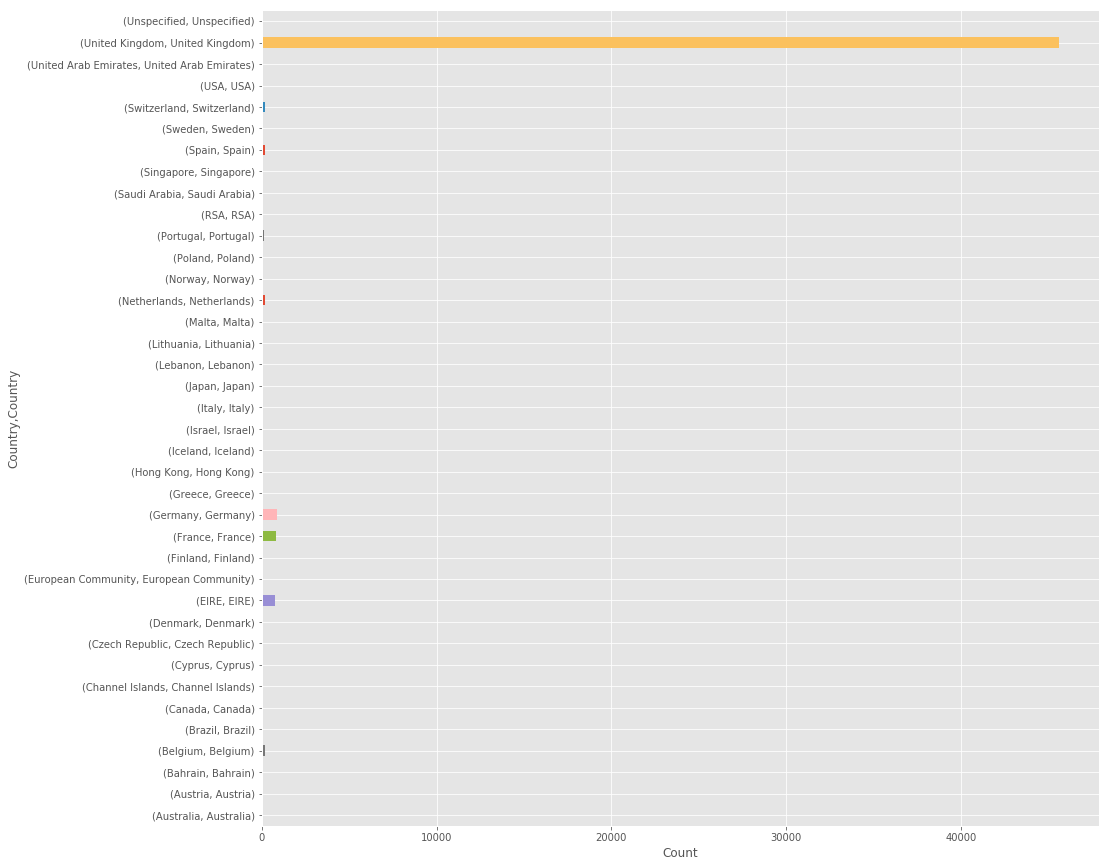

In [21]:
# Plot Countries
plt.style.use('ggplot')
plt.figure(figsize= (15,15))
plt.xlabel('Count')
temp['Country'].value_counts().plot(kind = 'barh', grid = True)
plt.show()

Majority of the orders are made from the UK. So lets create two categories UK and Non_UK

In [22]:
Country_n = []
for item in df_initial['Country']:
    if item == 'United Kingdom' :
        Country_n.append('UK')
    else:
        Country_n.append('Non_UK')
df_initial['Country_n'] = Country_n

## 2. Customers and orders

In [23]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3261,14253,3731


There are 3731 customers and they brought 3261 items in 14253 transactions

### Cancelling orders

Count the number of transactions corresponding to canceled orders, indicated by the letter C in InvoiceNo feature.This creates another variable OrderCancelled

In [24]:
OrderCanceled = []
for item in df_initial['InvoiceNo']:
    if 'C' in str(item):
        OrderCanceled.append(1)
    else:
        OrderCanceled.append(0)
df_initial['OrderCancelled'] = OrderCanceled 

In [25]:
(df_initial['OrderCancelled'] == 1).sum()/(df_initial['InvoiceNo'].shape[0])

0.01718185467683661

The number of cancellations is small, (∼1.72% of the total number of transactions) as depicted in Figure.

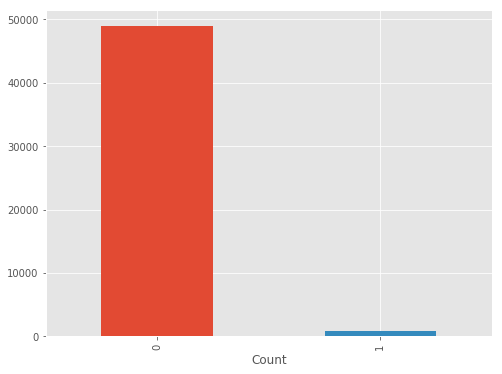

In [27]:
plt.figure(figsize= (8,6))
plt.xlabel('Count')
df_initial['OrderCancelled'].value_counts().plot(kind = 'bar', grid = True)
plt.show()

In [28]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_n,OrderCancelled
0,C544414,22960,JAM MAKING SET WITH JARS,-2,2011-02-18 14:54:00,3.75,13408,United Kingdom,UK,1
1,555276,48111,DOORMAT 3 SMILEY CATS,1,2011-06-01 17:28:00,15.79,nan,United Kingdom,UK,0
2,575656,22952,60 CAKE CASES VINTAGE CHRISTMAS,48,2011-11-10 14:29:00,0.55,13319,United Kingdom,UK,0
3,571636,20674,GREEN POLKADOT BOWL,16,2011-10-18 11:41:00,1.25,13509,United Kingdom,UK,0
4,576657,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-11-16 11:03:00,1.65,12720,Germany,Non_UK,0


## 3.InvoiceDate variable

Extract another variable, Season_month from the InvoiceDate variable

In [34]:
df_initial['Season_month'] = df_initial['InvoiceDate'].map(lambda x: x.to_pydatetime().month)

In [35]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_n,OrderCancelled,Season_month
0,C544414,22960,JAM MAKING SET WITH JARS,-2,2011-02-18 14:54:00,3.75,13408,United Kingdom,UK,1,2
1,555276,48111,DOORMAT 3 SMILEY CATS,1,2011-06-01 17:28:00,15.79,nan,United Kingdom,UK,0,6
2,575656,22952,60 CAKE CASES VINTAGE CHRISTMAS,48,2011-11-10 14:29:00,0.55,13319,United Kingdom,UK,0,11
3,571636,20674,GREEN POLKADOT BOWL,16,2011-10-18 11:41:00,1.25,13509,United Kingdom,UK,0,10
4,576657,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-11-16 11:03:00,1.65,12720,Germany,Non_UK,0,11


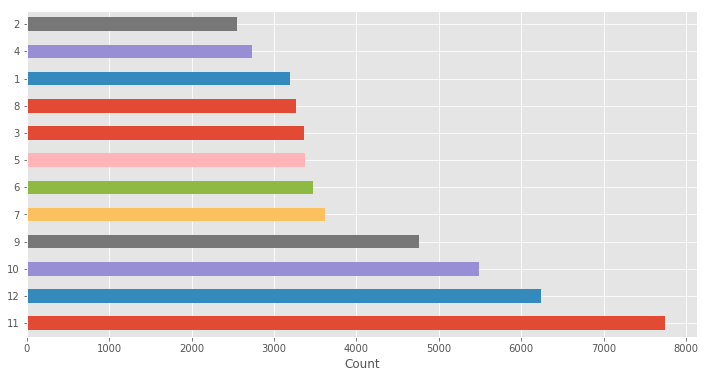

In [36]:
plt.figure(figsize= (12,6))
plt.xlabel('Count')
df_initial['Season_month'].value_counts().plot(kind = 'barh', grid = True)
plt.show()

Create four Quarter categories and put them in the variable Quarter_y


In [37]:
Quarter = []
for item in df_initial['Season_month']:
    if item < 4 :
        Quarter.append('Q1')
    elif item < 7:
        Quarter.append('Q2')
    elif item < 10:
        Quarter.append('Q3')
    else:
        Quarter.append('Q4')

In [38]:
df_initial['Quarter_y'] = Quarter

## 4.Creating Product Category variable

With the StockCode variable, lets create four product categories, counting the volume of sales.

In [40]:
Counts = df_initial['StockCode'].value_counts().to_dict()

In [41]:
Categ1 = [];Categ2 = [];Categ3 = [];Categ4 = []
for key,value in Counts.items():
    if value < 25:
        Categ4.append(str(key))
    elif value <= 50:
        Categ3.append(str(key))
    elif value <= 200:
        Categ2.append(str(key))
    else :
        Categ1.append(str(key))

In [42]:
Product_Categ = []
for item in df_initial['StockCode']: 
    if item in Categ1:
        Product_Categ.append(0)
    elif item in Categ2:
        Product_Categ.append(1)
    elif item in Categ3:
        Product_Categ.append(2)
    else:
        Product_Categ.append(3)

In [43]:
len(Product_Categ)

49820

Add the variable to the DataFrame.

In [44]:
df_initial['Prod_Categ'] = Product_Categ

In [45]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_n,OrderCancelled,Season_month,Quarter_y,Prod_Categ
0,C544414,22960,JAM MAKING SET WITH JARS,-2,2011-02-18 14:54:00,3.75,13408,United Kingdom,UK,1,2,Q1,3
1,555276,48111,DOORMAT 3 SMILEY CATS,1,2011-06-01 17:28:00,15.79,nan,United Kingdom,UK,0,6,Q2,3
2,575656,22952,60 CAKE CASES VINTAGE CHRISTMAS,48,2011-11-10 14:29:00,0.55,13319,United Kingdom,UK,0,11,Q4,3
3,571636,20674,GREEN POLKADOT BOWL,16,2011-10-18 11:41:00,1.25,13509,United Kingdom,UK,0,10,Q4,3
4,576657,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-11-16 11:03:00,1.65,12720,Germany,Non_UK,0,11,Q4,3


## 4. Numerical variables

Two numerical variables are Quantity and UnitPrice,

(-5000, 5000)

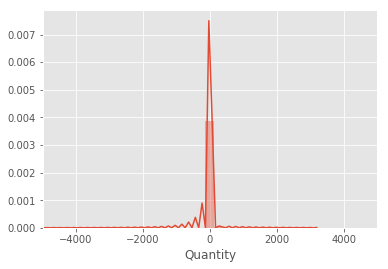

In [47]:
sns.distplot(df_initial["Quantity"])
plt.xlim(-5000,5000)

(0, 500)

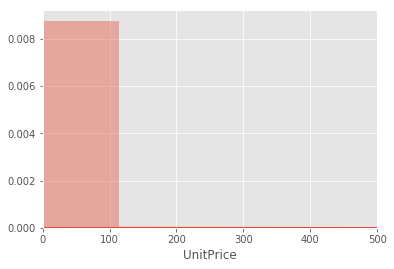

In [48]:
sns.distplot(df_initial["UnitPrice"])
plt.xlim(0,500)

In [49]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49820 entries, 0 to 49999
Data columns (total 13 columns):
InvoiceNo         49820 non-null object
StockCode         49820 non-null object
Description       49820 non-null object
Quantity          49820 non-null int64
InvoiceDate       49820 non-null datetime64[ns]
UnitPrice         49820 non-null float64
CustomerID        49820 non-null object
Country           49820 non-null object
Country_n         49820 non-null object
OrderCancelled    49820 non-null int64
Season_month      49820 non-null int64
Quarter_y         49820 non-null object
Prod_Categ        49820 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(7)
memory usage: 5.3+ MB


In [50]:
X = df_initial.drop(['InvoiceNo','StockCode','Description','InvoiceDate','CustomerID','Country','Season_month','Prod_Categ'], axis = 1)
y = df_initial['Prod_Categ']

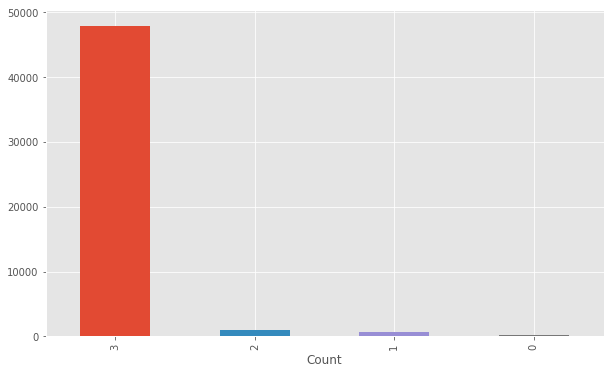

In [51]:
plt.figure(figsize= (10,6))
plt.xlabel('Count')
y.value_counts().plot(kind = 'bar', grid = True)
plt.show()


The output variable is highly skewed. So normalization is required in the training stage

Encode categorical variables

In [52]:
categorical = ['OrderCancelled','Quarter_y', 'Country_n']
categorical_variables = categorical
X = pd.get_dummies(X, columns = categorical_variables)

In [53]:
#label encoder
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

Now proceed to Feature scaling

In [55]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

Create train and test sets

In [56]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Using Deep Learning method

In [57]:
#Import TensorFlow and Keras
import tensorflow as tf
from keras.utils import np_utils
tf.logging.set_verbosity(tf.logging.INFO)

Using TensorFlow backend.


In [58]:
#Encode y_train and y_test using to_categorical in np.utils
from sklearn.preprocessing import LabelEncoder
def encode_neural_net_y(y):
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_y = encoder.transform(y)
    new_y = np_utils.to_categorical(encoded_y)
    return new_y
# Encoding y_train and y_test
y_train = encode_neural_net_y(y_train)
y_test = encode_neural_net_y(y_test)

In [59]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (39856, 10)
Shape of y_train:  (39856, 4)
Shape of X_test:  (9964, 10)
Shape of y_test:  (9964, 4)


In [60]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.normalization import BatchNormalization

# create model
model = Sequential()
model.add(Dense(35, input_dim=10, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

The layers are created using kers.layers. We build 2-layer fully connected neural network with 35 neurons in hidden layer.

Batch normalization layer is inserted between hidden layer and output layer. This can take into account the skewness in the data.

The categorical_crossentropy is used as loss function and updating method/ optimizer is ADAM. Activation for the input layers is relu and that for the ouput layer is softmax

In [61]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 35)                385       
_________________________________________________________________
batch_normalization_1 (Batch (None, 35)                140       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 144       
Total params: 669
Trainable params: 599
Non-trainable params: 70
_________________________________________________________________


Now train the model to predict the Product Categories from the transaction data

In [62]:
history = model.fit(np.array(X_train), np.array(y_train), epochs=30, batch_size=40, verbose=1)

Epoch 1/30
39856/39856 [==============================] - 1s 23us/step - loss: 0.3443 - acc: 0.9261
Epoch 2/30
39856/39856 [==============================] - 1s 15us/step - loss: 0.1932 - acc: 0.9632
Epoch 3/30
39856/39856 [==============================] - 1s 15us/step - loss: 0.1929 - acc: 0.9632
Epoch 4/30
39856/39856 [==============================] - 1s 15us/step - loss: 0.1924 - acc: 0.9632
Epoch 5/30
39856/39856 [==============================] - 1s 15us/step - loss: 0.1917 - acc: 0.9633
Epoch 6/30
39856/39856 [==============================] - 1s 15us/step - loss: 0.1922 - acc: 0.9632
Epoch 7/30
39856/39856 [==============================] - 1s 14us/step - loss: 0.1903 - acc: 0.9633
Epoch 8/30
39856/39856 [==============================] - 1s 14us/step - loss: 0.1903 - acc: 0.9632
Epoch 9/30
39856/39856 [==============================] - 1s 14us/step - loss: 0.1902 - acc: 0.9632
Epoch 10/30
39856/39856 [==============================] - 1s 14us/step - loss: 0.1900 - acc: 0.9632

In [63]:
scores = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print("====================[TEST SCORE]====================")
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

====================[TEST SCORE]====================
acc: 96.18%


In [64]:
scores = model.evaluate(np.array(X_train), np.array(y_train), verbose=0)
print("====================[TRAIN SCORE]====================")
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

====================[TRAIN SCORE]====================
acc: 96.26%


# Conclusion

The model has a farily good performance on the train as well as on the test sets. Features are analysed and new features have been created to help with the predictions.
The test set accuracy is lower than the train set accuarcy by only a negligible percentage, yet the effect of regularization is to be studied
Another dimension to the feature engineering can be extracing the product information from the Description variable, using Natural Language Processing libraries like nltk.